In [1]:
####### Imports #######
import re
import os
import sys
sys.path.append('/home/pfa/Documents/PathologicalGaitClassification')
import numpy as np
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, Input, ConvLSTM2D, GlobalAveragePooling2D, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sort import sort_nicely
from multiprocessing import Process, Manager
import pickle
import json

Using TensorFlow backend.


In [2]:
## Get datase
base_dir = '/home/datasets/GAIT-IT'
metadata_dir = '/home/datasets/metadata'

sample_count = 0
# all_images = {'train': [], 'validation': [], 'test': []}
# all_labels = {'train': [], 'validation': [], 'test': []}
subjects_data = {}
# train_subjs = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s21']
# validation_subjs = ['s19','s20']
# test_subjs = ['s22','s23']
train_images = []; train_labels = []
validation_images = []; validation_labels = []
test_images = []; test_labels = []

classes = {'Diplegic' : 0, 'Hemiplegic' : 1, 'Neuropathic' : 2, 'Normal' : 3, 'Parkinson' : 4}
classes_inv = {0 : 'Diplegic', 1 : 'Hemiplegic', 2 : 'Neuropathic', 3 : 'Normal', 4 : 'Parkinson'}

In [3]:
## Train silhouettes directories
def sets(train_subjs,validation_subjs,test_subjs):
    sample_count = 0
    all_images = {'train': [], 'validation': [], 'test': []}
    all_labels = {'train': [], 'validation': [], 'test': []}

    # Sort pathologies, OCD purposes only
    pathologies = list(classes.keys())
    sort_nicely(pathologies)
    for pathology in pathologies:

        pathology_dir = base_dir + '/{}'.format(pathology)
        print(pathology_dir)
        pathology_subj_folders = [name for name in os.listdir(pathology_dir) if os.path.isdir(os.path.join(pathology_dir, name))]
        sort_nicely(pathology_subj_folders)
        
        # /Pathology/subj{i}/silhouettes/subj_{i}-pat_{j}-lvl_{k}-{l}_{direction}
        for subj_folder in pathology_subj_folders:

            if subj_folder in train_subjs: subj_set = 'train'
            elif subj_folder in validation_subjs: subj_set = 'validation'
            elif subj_folder in test_subjs: subj_set = 'test'

            subj_folder_dir = os.path.join(pathology_dir, subj_folder)
            # print(subj_folder_dir)
            subj_silhouettes_dir = os.path.join(subj_folder_dir, 'silhouettes', 'side_view')
            # print(subj_silhouettes_dir)

            subj_silhouettes_folders = [name for name in os.listdir(subj_silhouettes_dir) if os.path.isdir(os.path.join(subj_silhouettes_dir, name))]
            sort_nicely(subj_silhouettes_folders)

            folders = [f for f in subj_silhouettes_folders if '_' in f]
            for folder in folders:

                # Initialize dictionary to store key frames
                key_frames = {}

                # Directory with metadata about current folder
                subj_silhouettes_metadata_dir = subj_silhouettes_dir.replace('GAIT-IT', 'metadata')
                subj_pat_metadata = os.path.join(subj_silhouettes_metadata_dir,'metadata/key_frames.json')

                with open(subj_pat_metadata) as f:
                    key_frames = json.load(f)

                # Directory with the sillouettes images
                subj_pat_lvl_dir = os.path.join(subj_silhouettes_dir, folder)
                # print(subj_pat_lvl_dir)

                files = os.listdir(subj_pat_lvl_dir)
                sort_nicely(files)
                file_names = [files[f] for f in key_frames[folder]]
                
                # Convert images to numpy arrays, put in batches
                # for file_name in file_names:
                for i in range(0, len(file_names)-8, 9):
                    for j in range(0,9):
                        file_path = os.path.join(subj_pat_lvl_dir, file_names[i+j])
                        img = image.load_img(file_path, target_size=(224, 224))
                        img_tensor = image.img_to_array(img)
                        sample_count += 1

                        all_images[subj_set].append(img_tensor)
                        all_labels[subj_set].append(classes[pathology])
    print(len(all_images['train'])); print(len(all_images['validation'])); print(len(all_images['test']))
    print(len(all_labels['train'])); print(len(all_labels['validation'])); print(len(all_labels['test']))
    
    return all_images, all_labels

In [8]:
def create_train(k, all_history):

    validation_subjs = ['s{}'.format(i) for i in range(k,k+3)]
    test_subjs = ['s13','s21']
    train_subjs = ['s{}'.format(i) for i in range(1,23) if 's{}'.format(i) not in validation_subjs and 's{}'.format(i) not in test_subjs]

    print(train_subjs, validation_subjs, test_subjs)

    all_images, all_labels = sets(train_subjs=train_subjs, validation_subjs=validation_subjs, test_subjs=test_subjs)

    img_height = 224
    img_width = 224
    no_of_frames = 9
    channels = 3
    no_of_epochs = 50
    batch_size_value = 5

    cnn_base = Xception(input_shape=(img_width, img_height, channels), weights="imagenet", include_top=False)
    cnn_base.trainable = False

    # cnn_base.summary()

    all_labels_array = {'train': [], 'validation': [], 'test': []}
    all_features_array = {'train': [], 'validation': [], 'test': []}

    for subj_set in all_images:
        print(subj_set)
        for i in range(0,len(all_images[subj_set])-8,9):
            features_array = np.stack(all_images[subj_set][i:i+9])
            predictions = cnn_base.predict(features_array)
            all_labels_array[subj_set].append(all_labels[subj_set][i])
            all_features_array[subj_set].append(predictions)

        all_features_array[subj_set] = np.array(all_features_array[subj_set])
        all_labels_array[subj_set] = np.array(all_labels_array[subj_set])
        all_labels_array[subj_set] = to_categorical(all_labels_array[subj_set])

        print(all_features_array[subj_set].shape)
        print(all_labels_array[subj_set].shape)

    img_height = 7
    img_width = 7
    no_of_frames = 9
    channels = 2048
    no_of_epochs = 50
    batch_size_value = 5

    input_video = Input(shape=(no_of_frames, img_width, img_height, channels))
    encoded_sequence = ConvLSTM2D(64, kernel_size=(5, 5), strides=(1, 1),padding='same', return_sequences=False)(input_video)

    GAP_layer = GlobalAveragePooling2D()(encoded_sequence)

    hidden_layer_1 = Dense(activation="relu", units=1024)(GAP_layer)
    drop_layer=Dropout(0.2)(hidden_layer_1)
    hidden_layer_2 = Dense(activation="relu", units=512)(drop_layer)
    outputs = Dense(5, activation="softmax")(hidden_layer_2)
    model = Model([input_video], outputs)

    # model.summary()
    nadam_optimizer = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

    model.compile(loss="categorical_crossentropy", optimizer=nadam_optimizer, metrics=["accuracy"])


    # Save the model according to the conditions
    checkpoint = ModelCheckpoint("Xception/models/Xception_convLSTM2D{}.h5".format(k), monitor='val_acc', verbose=1, save_best_only=True,
                                save_weights_only=False,
                                mode='auto', period=1)

    history = model.fit(
            all_features_array['train'], all_labels_array['train'],
            validation_data=(all_features_array['validation'], all_labels_array['validation']),
            verbose=1,
            epochs=no_of_epochs,
            callbacks=[checkpoint])

    all_history.append(history.history)

In [9]:
# Create list to store models history through k-folds iterations for cross validation
all_history = Manager().list()

# Define number iterations for k-folds
for k in range(1,11):
    # Train model with process to free GPU memory after training
    p = Process(target=create_train, args=(k, all_history))
    p.start()
    p.join()

# Conver manager list back to normal list
history = [item for item in all_history]

# Store performance history of each fold
with open("Xception/history/all_history", 'wb') as f:
    pickle.dump(history,f)

_________________________________________________________________________
block11_sepconv1_act (Activatio (None, 14, 14, 728)  0           add_9[0][0]                      
__________________________________________________________________________________________________
block11_sepconv1 (SeparableConv (None, 14, 14, 728)  536536      block11_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block11_sepconv1_bn (BatchNorma (None, 14, 14, 728)  2912        block11_sepconv1[0][0]           
__________________________________________________________________________________________________
block11_sepconv2_act (Activatio (None, 14, 14, 728)  0           block11_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block11_sepconv2 (SeparableConv (None, 14, 14, 728)  536536      block11_sepconv2_act[0][0]       
___________________________________

In [ ]:
with open("Xception/history/all_history", 'rb') as f:
    all_history = pickle.load(f)

10


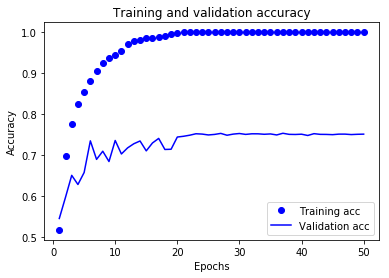

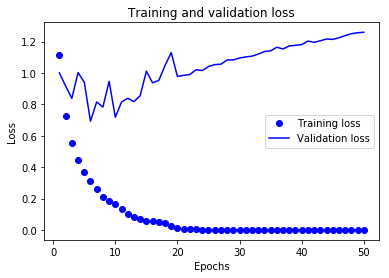

In [10]:
## Plot results
print(len(all_history))

average_acc = [np.mean([x["acc"][i] for x in all_history]) for i in range(50)]
average_loss = [np.mean([x["loss"][i] for x in all_history]) for i in range(50)]
average_val_acc = [np.mean([x["val_acc"][i] for x in all_history]) for i in range(50)]
average_val_loss = [np.mean([x["val_loss"][i] for x in all_history]) for i in range(50)]

plt.plot(range(1, len(average_acc) + 1), average_acc, 'bo', label = 'Training acc')
plt.plot(range(1, len(average_val_acc) + 1), average_val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Xception/plots/all_history_acc')

plt.figure()

plt.plot(range(1, len(average_loss) + 1), average_loss, 'bo', label = 'Training loss')
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Xception/plots/all_history_loss')

plt.show()

In [13]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

def evaluate_model(k, confusion_matrices):

    validation_subjs = ['s{}'.format(i) for i in range(k,k+3)]
    test_subjs = ['s13','s21']
    train_subjs = ['s{}'.format(i) for i in range(1,23) if 's{}'.format(i) not in validation_subjs and 's{}'.format(i) not in test_subjs]

    print(train_subjs, validation_subjs, test_subjs)

    all_images, all_labels = sets(train_subjs=train_subjs, validation_subjs=validation_subjs, test_subjs=test_subjs)

    img_height = 224
    img_width = 224
    no_of_frames = 9
    channels = 3
    no_of_epochs = 50
    batch_size_value = 5

    cnn_base = Xception(input_shape=(img_width, img_height, channels), weights="imagenet", include_top=False)
    cnn_base.trainable = False

    cnn_base.summary()

    all_labels_array = {'train': [], 'validation': [], 'test': []}
    all_features_array = {'train': [], 'validation': [], 'test': []}

    for subj_set in all_images:
        print(subj_set)
        for i in range(0,len(all_images[subj_set])-8,9):
            features_array = np.stack(all_images[subj_set][i:i+9])
            predictions = cnn_base.predict(features_array)
            all_labels_array[subj_set].append(all_labels[subj_set][i])
            all_features_array[subj_set].append(predictions)

        all_features_array[subj_set] = np.array(all_features_array[subj_set])
        all_labels_array[subj_set] = np.array(all_labels_array[subj_set])
        all_labels_array[subj_set] = to_categorical(all_labels_array[subj_set])

        print(all_features_array[subj_set].shape)
        print(all_labels_array[subj_set].shape)

    # Load best model from checkpoint of current fold
    model = load_model('Xception/models/Xception_convLSTM2D{}.h5'.format(k))
    
    # Check validation accuracy
    results = model.evaluate(all_features_array['validation'], all_labels_array['validation'])
    print(results)

    predictions = model.predict(all_features_array['validation'])
    conf_mat = confusion_matrix(np.argmax(all_labels_array['validation'], axis=1), np.argmax(predictions, axis=1))
    confusion_matrices.append(conf_mat)

In [12]:
# Load best models of each fold and compute confusion matrices
confusion_matrices = Manager().list()
for k in range(1,11):
    p = Process(target=evaluate_model, args=(k, confusion_matrices))
    p.start()
    p.join()

# Convert manager list back to normal list
conf_matrices = [item for item in confusion_matrices]

# Store list with confusion matrices from every fold
with open("Xception/confusion matrices/confusion_matrices", 'wb') as f:
    pickle.dump(conf_matrices,f)

['s4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's22'] ['s1', 's2', 's3'] ['s13', 's21']
/home/datasets/GAIT-IT/Diplegic
/home/datasets/GAIT-IT/Hemiplegic
/home/datasets/GAIT-IT/Neuropathic
/home/datasets/GAIT-IT/Normal
/home/datasets/GAIT-IT/Parkinson
27171
4212
2952
27171
4212
2952
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Process Process-15:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-11-e1ffb8a7f5d1>", line 18, in evaluate_model
    results = model.evaluate(all_images['validation'], all_labels['validation'])
  File "/home/pfa/.local/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 941, in evaluate
    steps=steps)
  File 

KeyboardInterrupt: 

In [ ]:
with open("Xception/confusion matrices/confusion_matrices", 'rb') as f:
    confusion_matrices = pickle.load(f)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Function to display confusion matrices
def DisplayCM(CM, title, save):

    display_labels = ['Diplegic', 'Hemiplegic', 'Neuropathic', 'Normal', 'Parkinson']
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                                display_labels=display_labels)
    disp = disp.plot(include_values=True,
                    cmap='viridis', ax=ax, xticks_rotation='horizontal')
    plt.title(title)
    plt.tight_layout()

    if save: plt.savefig('Xception/plots/' + title)


# Initialize normalized and average CMs and normalized CMs list
cmAVG = np.zeros((5,5))
cmpercent = np.zeros((5,5))
cmpercentList = []

i = 1
# Create list for eachconfusion matrix in percentages
for cm in confusion_matrices:
    display_labels = ['Diplegic', 'Hemiplegic', 'Neuropathic', 'Normal', 'Parkinson']

    cmpercent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmpercentList.append(cmpercent)

   # Plot average CM of current model
    DisplayCM(CM=cmpercent, title='cmpercent{}'.format(i), save=True)
    i += 1


for i in range(0,5):
    for j in range(0,5):
        cmAVG[i][j] = np.mean([x[i][j] for x in cmpercentList])

# Plot average CM of current model
DisplayCM(CM=cmAVG, title='AVG', save=True)

print(cmAVG)
print(np.mean([cmAVG[0][0],cmAVG[1][1], cmAVG[2][2], cmAVG[3][3], cmAVG[4][4]]))